In [75]:
import imageio.v3 as iio
import pandas as pd
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [76]:
# read in data frame with corresponding trial and image data
df = pd.read_csv("imagedf.csv")
print(df.head())

   Unnamed: 0                                    subjID         levelID  \
0           1  connect-1DF28D04D4BC4AD0A9B59DD0E935393A       basic_far   
1           2  connect-1DF28D04D4BC4AD0A9B59DD0E935393A       basic_far   
2           3  connect-1DF28D04D4BC4AD0A9B59DD0E935393A       basic_far   
3           4  connect-1DF28D04D4BC4AD0A9B59DD0E935393A  boomerang_left   
4           5  connect-1DF28D04D4BC4AD0A9B59DD0E935393A  boomerang_left   

   gravX  gravY  radius  numAttempts  success  \
0   0.00    2.5      20            0     fail   
1   0.00    2.5      20            1     fail   
2   0.00    2.5      20            2  success   
3   0.25    1.0      30            0     fail   
4   0.25    1.0      30            1     fail   

                                             imageID  \
0  connect-1DF28D04D4BC4AD0A9B59DD0E935393A_img0.png   
1  connect-1DF28D04D4BC4AD0A9B59DD0E935393A_img1.png   
2  connect-1DF28D04D4BC4AD0A9B59DD0E935393A_img2.png   
3  connect-1DF28D04D4BC4AD0A9B

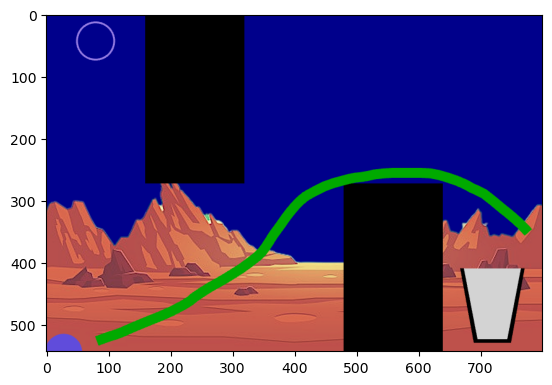

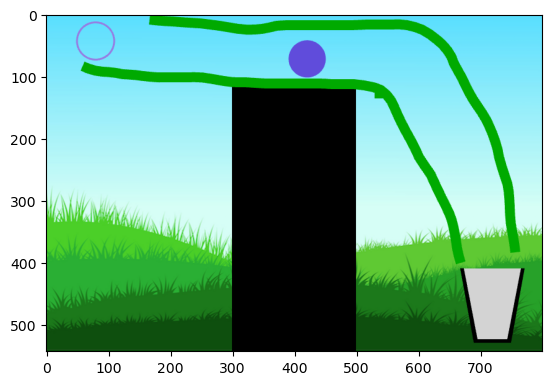

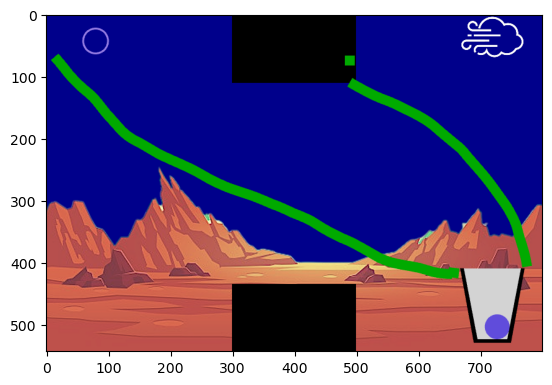

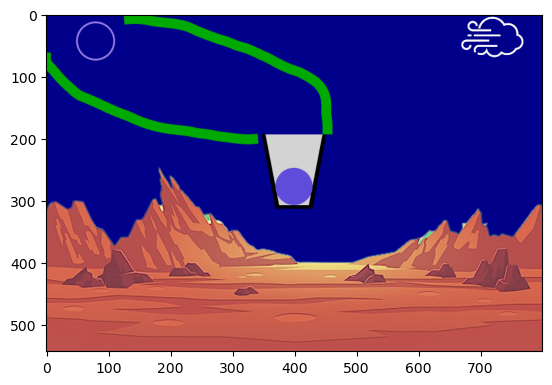

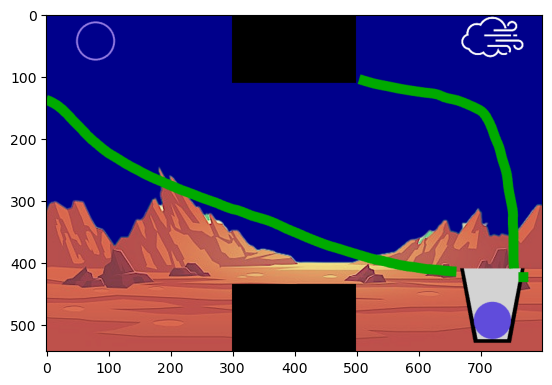

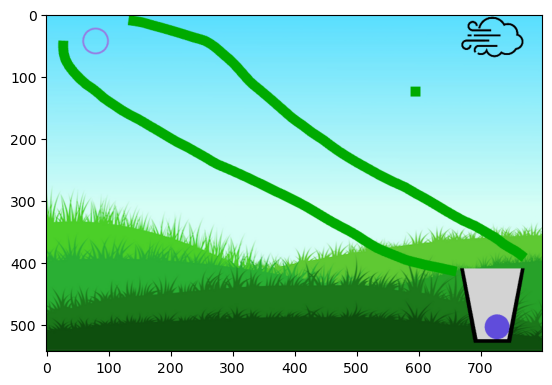

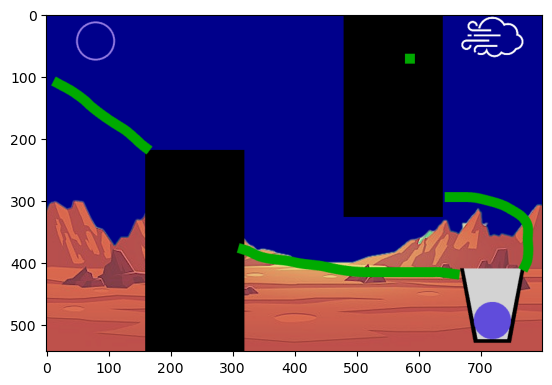

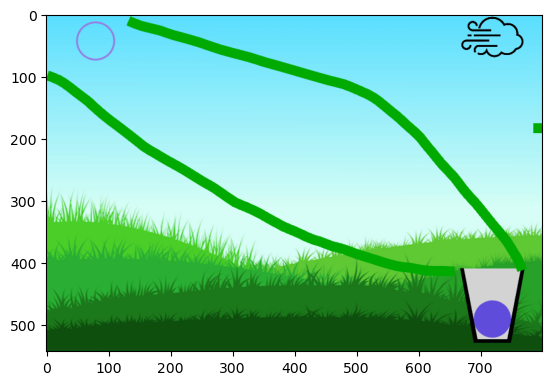

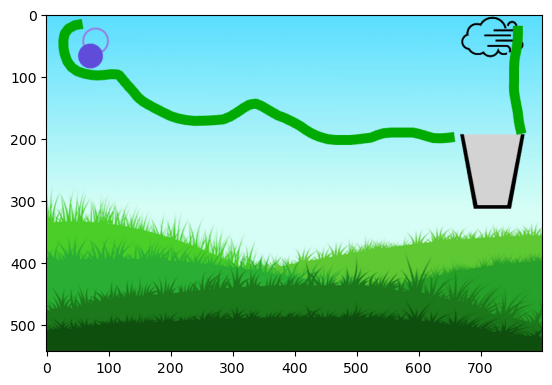

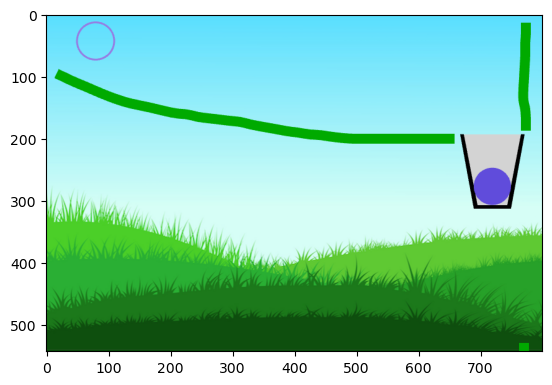

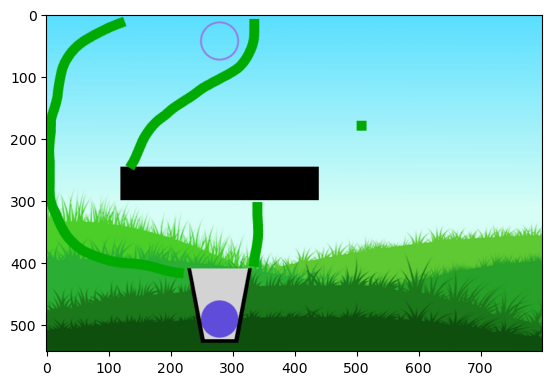

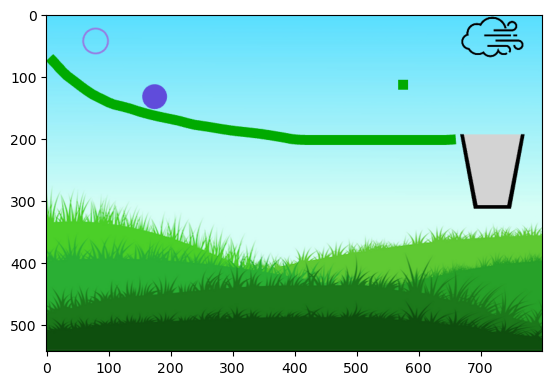

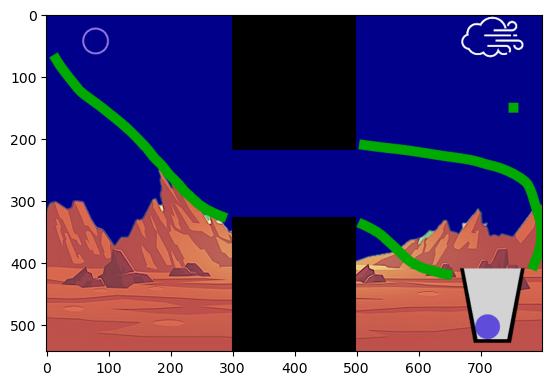

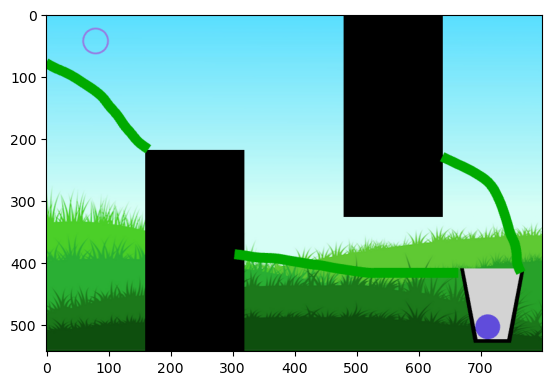

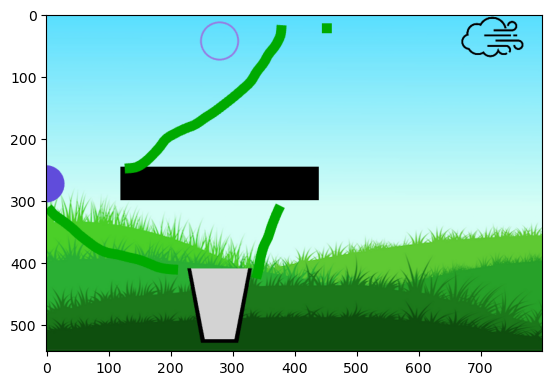

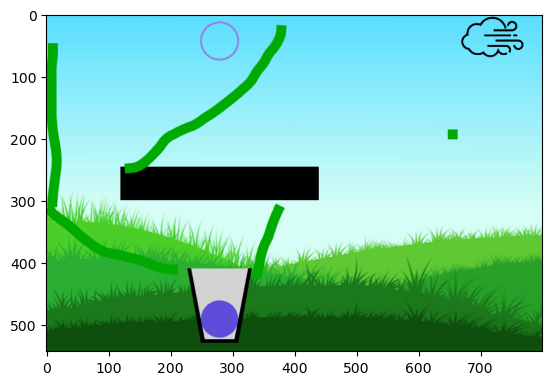

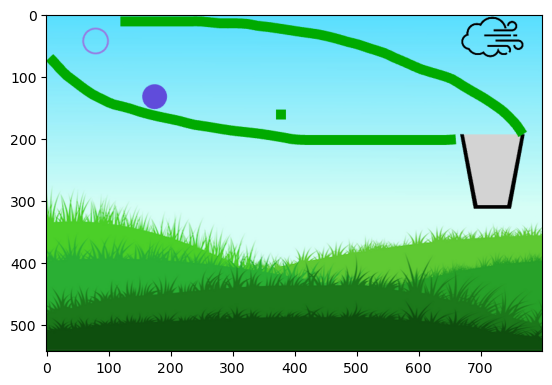

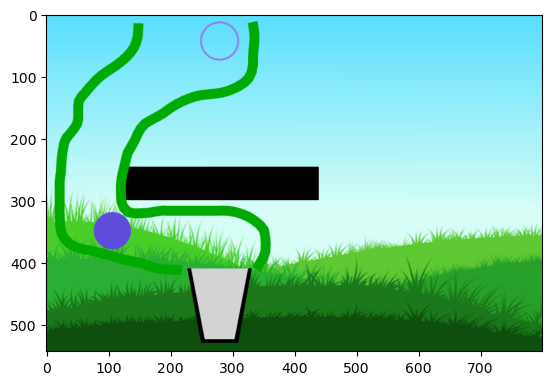

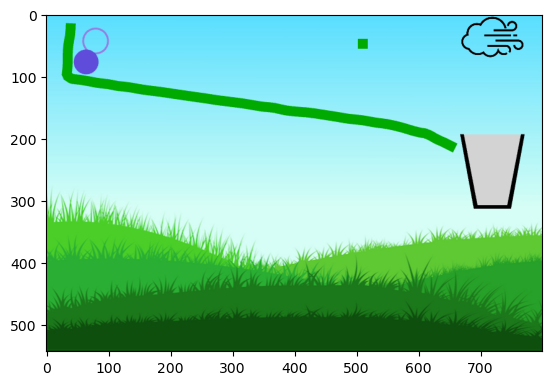

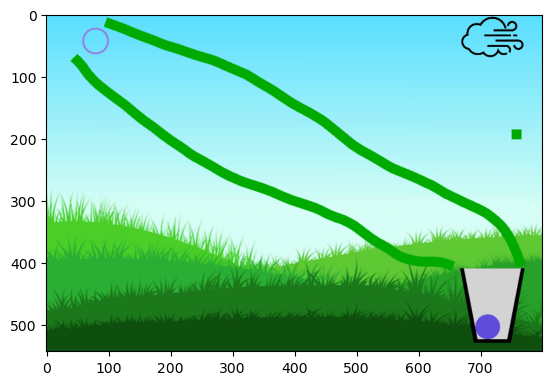

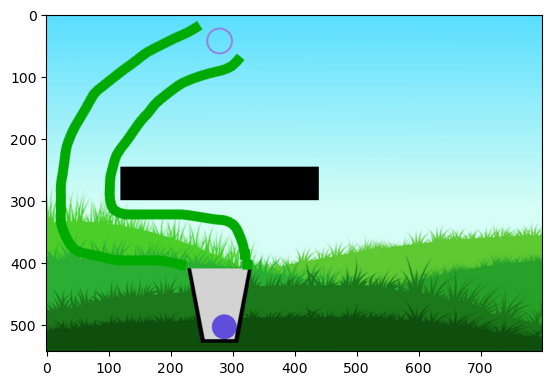

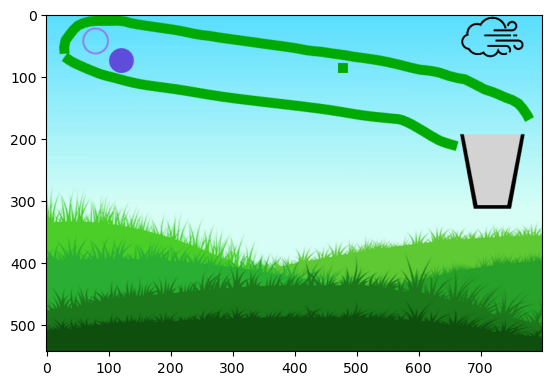

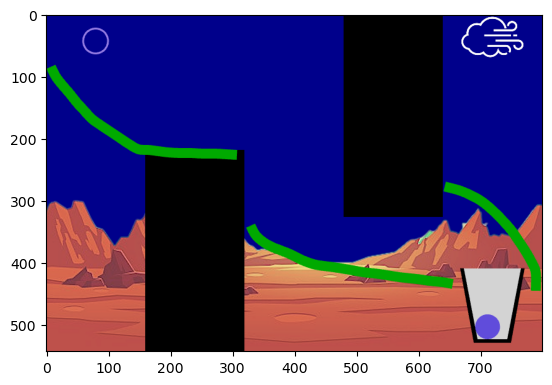

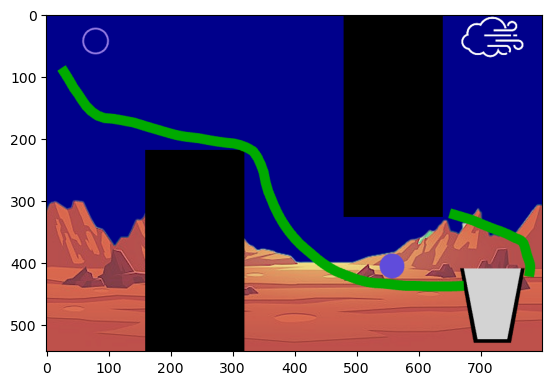

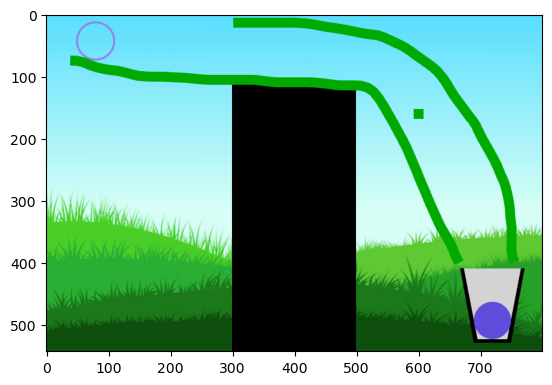

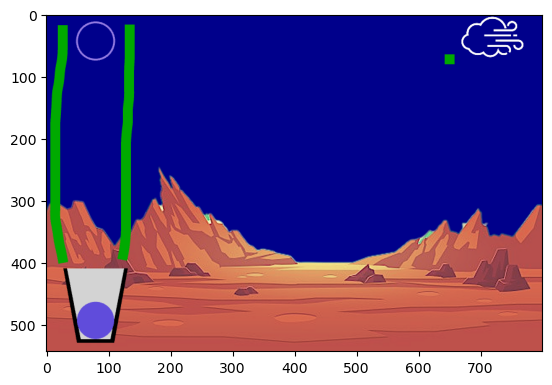

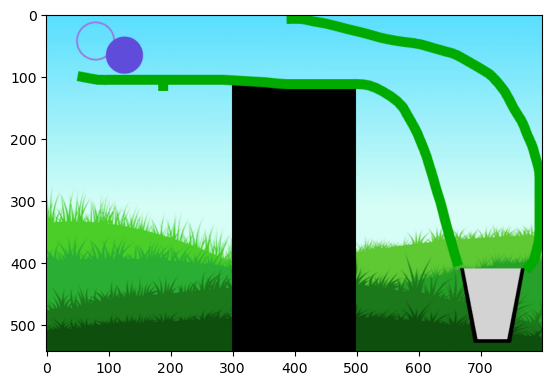

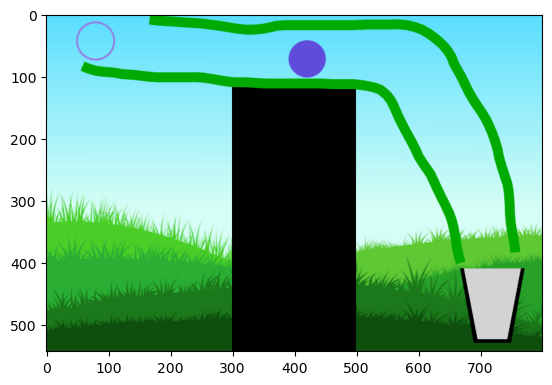

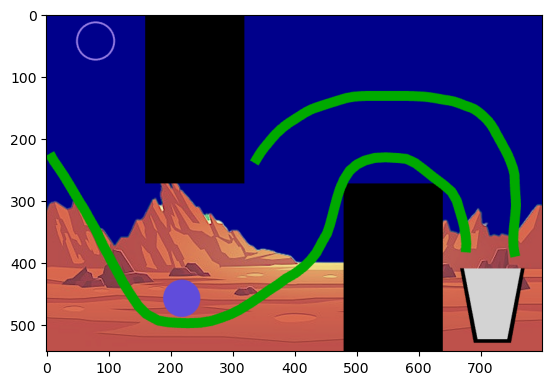

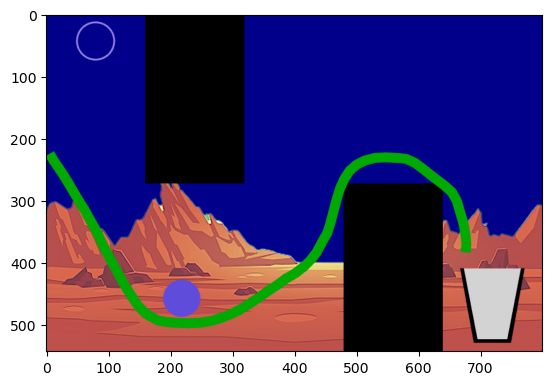

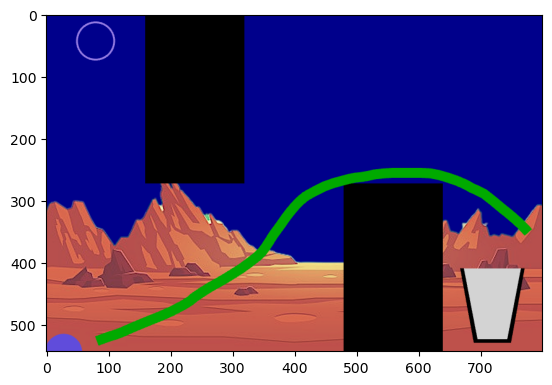

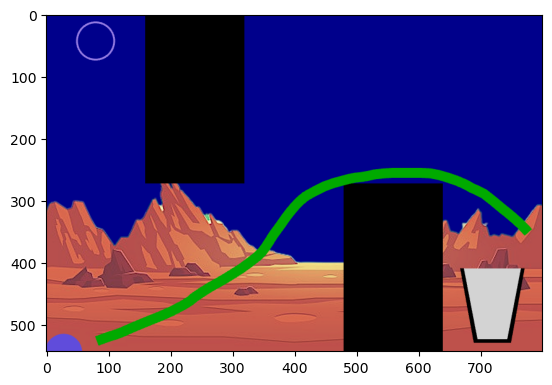

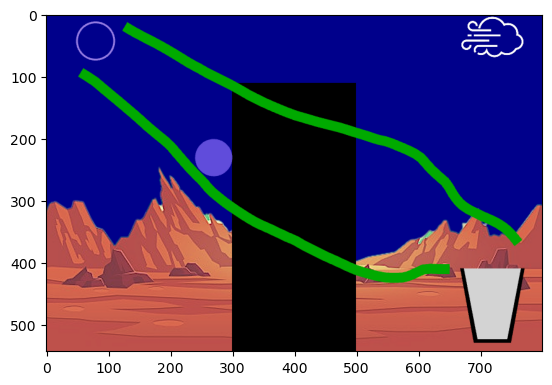

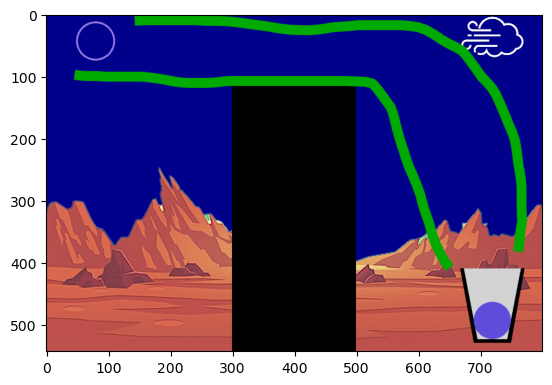

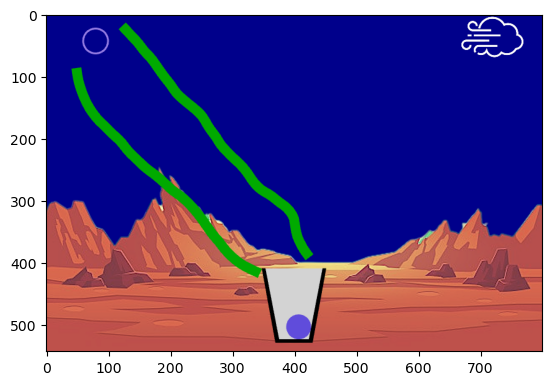

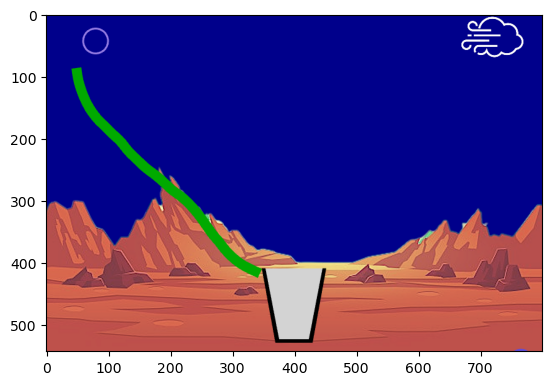

In [78]:
# test pulling up one participant's original images
for im_path in glob.glob("../../game/data/img/pilot1/connect-0F07CDB90B904FB79C385106E46337DE/*.png"):
    img = mpimg.imread(im_path)
    imgplot = plt.imshow(img[57:,:])
    plt.show()

# Convert image to binary

In [173]:
# function converts image to binary and return edited image
def toBinary(image):
    # convert image to numpy array
    img_array = np.array(image)

    # define green line that we are targeting
    target_color = np.array([0, 170, 0, 255])

    # binary mask where pixels matching the target color = True
    mask = np.all(img_array == target_color, axis=-1)
    
    # set pixels matching the target color to black and everything else to white
    img_array[mask] = [0, 0, 0, 255]  # Black
    img_array[~mask] = [255, 255, 255, 255]  # White

    # convert the NumPy array back to an image
    result_img = Image.fromarray(img_array)
    
    return result_img

In [234]:
# convert all images to binary
Dict = {}
for im_path in glob.glob("../../game/data/img/pilot1/*/*.png"):
    # get subject ID info
#     subjID = im_path.split("connect-",1)[1][0:10]
    
    # get image ID info
    imageID = im_path.split("pilot1/",1)[1][41:]
#     dfrow = df[df['imageID'].str.contains(imageID)]
#     print(dfrow.iloc[0]['levelID'])
    
    # open each image
    img = Image.open(im_path)
    
    # convert images to binary
    new_img = toBinary(img)
    
    # save edited images to dictionary
    Dict[imageID] = new_img
    
    # show image
#     imgplot = plt.imshow(new_img)
#     plt.show()


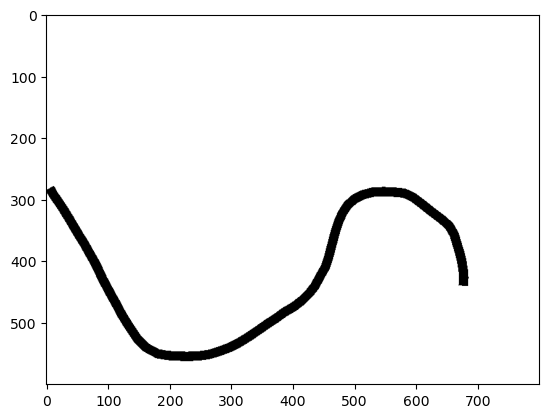

In [175]:
# check image saving by pulling up an example image
plt.imshow(Dict['connect-0F07CDB90B904FB79C385106E46337DE_img5.png'])

# Compare images

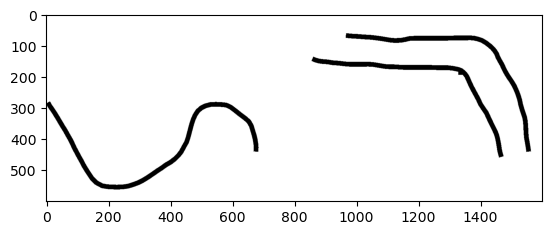

In [180]:
s1 = Dict['connect-0F07CDB90B904FB79C385106E46337DE_img5.png']
s2 = Dict['connect-0F07CDB90B904FB79C385106E46337DE_img9.png']
plt.imshow(np.hstack((s1, s2)))

Text(0.5, 1.0, 'img9')

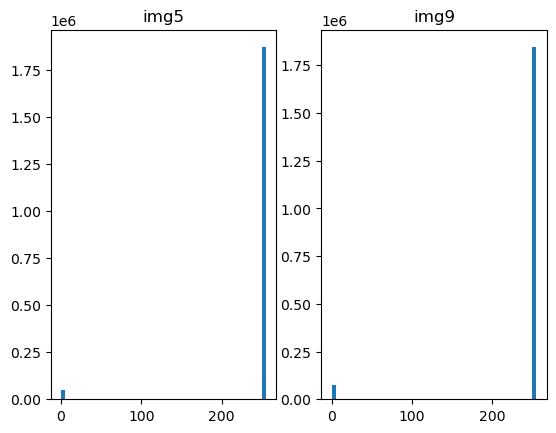

In [185]:
fig, axes = plt.subplots(1, 2)
s1_arr = np.asarray(s1).ravel()
axes[0].hist(s1_arr, bins=50)
axes[0].set_title('img5')
s2_arr = np.asarray(s2).ravel()
axes[1].hist(s2_arr, bins=50)
axes[1].set_title('img9')

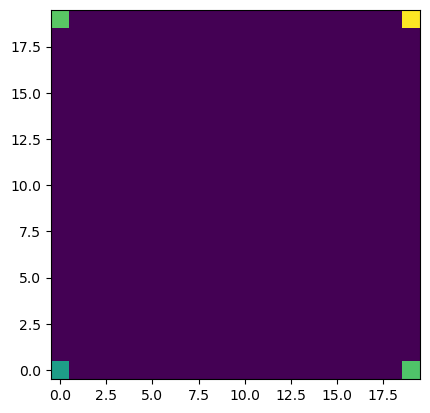

In [207]:
np.corrcoef(s1_arr, s2_arr)[0, 1]

hist_2d, x_edges, y_edges = np.histogram2d(s1_arr,s2_arr,bins=20)
# plt.imshow(hist_2d.T, origin='lower')
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')

## Test mutual information with full colored image

Text(0.5, 1.0, 'img6')

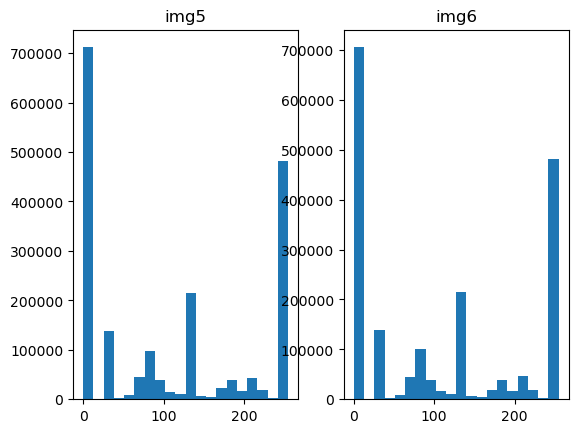

In [152]:
img1 = Image.open("../../game/data/img/pilot1/connect-0F07CDB90B904FB79C385106E46337DE/connect-0F07CDB90B904FB79C385106E46337DE_img5.png")
img2 = Image.open("../../game/data/img/pilot1/connect-0F07CDB90B904FB79C385106E46337DE/connect-0F07CDB90B904FB79C385106E46337DE_img6.png")

fig, axes = plt.subplots(1, 2)
axes[0].hist(np.asarray(img1).ravel(), bins=20)
axes[0].set_title('img5')
axes[1].hist(np.asarray(img2).ravel(), bins=20)
axes[1].set_title('img6')

0.9654034814891289

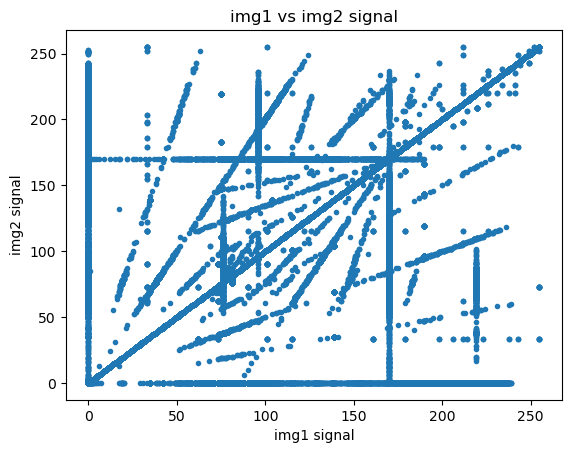

In [156]:
plt.plot(np.asarray(img1).ravel(), np.asarray(img2).ravel(), '.')
plt.xlabel('img1 signal')
plt.ylabel('img2 signal')
plt.title('img1 vs img2 signal')
np.corrcoef(np.asarray(img1).ravel(), np.asarray(img2).ravel())[0, 1]

# Measure mutual information

In [195]:
def mutual_information(hgram):
    # Mutual information for joint histogram
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [239]:
def compareImgs(img1, img2):
    s1 = Dict[img1]
    s2 = Dict[img2]
#     plt.imshow(np.hstack((s1, s2)))
    s1_arr = np.asarray(s1).ravel()
    s2_arr = np.asarray(s2).ravel()
    hist_2d, x_edges, y_edges = np.histogram2d(s1_arr,s2_arr,bins=20)
    return mutual_information(hist_2d)

## Test mutual information across within participant images

In [240]:
print(compareImgs('connect-0F07CDB90B904FB79C385106E46337DE_img3.png', 'connect-0F07CDB90B904FB79C385106E46337DE_img6.png'))

4.387113103632102e-06


In [251]:
subjdf[0:10]

1007    connect-0F07CDB90B904FB79C385106E46337DE_img0.png
1008    connect-0F07CDB90B904FB79C385106E46337DE_img1.png
1009    connect-0F07CDB90B904FB79C385106E46337DE_img2.png
1010    connect-0F07CDB90B904FB79C385106E46337DE_img3.png
1011    connect-0F07CDB90B904FB79C385106E46337DE_img4.png
1012    connect-0F07CDB90B904FB79C385106E46337DE_img5.png
1013    connect-0F07CDB90B904FB79C385106E46337DE_img6.png
1014    connect-0F07CDB90B904FB79C385106E46337DE_img7.png
1015    connect-0F07CDB90B904FB79C385106E46337DE_img8.png
1016    connect-0F07CDB90B904FB79C385106E46337DE_img9.png
Name: imageID, dtype: object

In [277]:
samplemidf = pd.DataFrame()
data_list = []
axis_imgs = []
subjdf = df[df['imageID'].str.contains('connect-0F07CDB90B904FB79C385106E46337DE')]['imageID']
for a in subjdf[0:10]:
    axis_imgs.append(Dict[a])
    for b in subjdf[0:10]:
        row = {'imgA': a, 'imgB': b, 'mutualinfo': compareImgs(a, b)}
        data_list.append(row) 

samplemidf = pd.DataFrame(data_list)

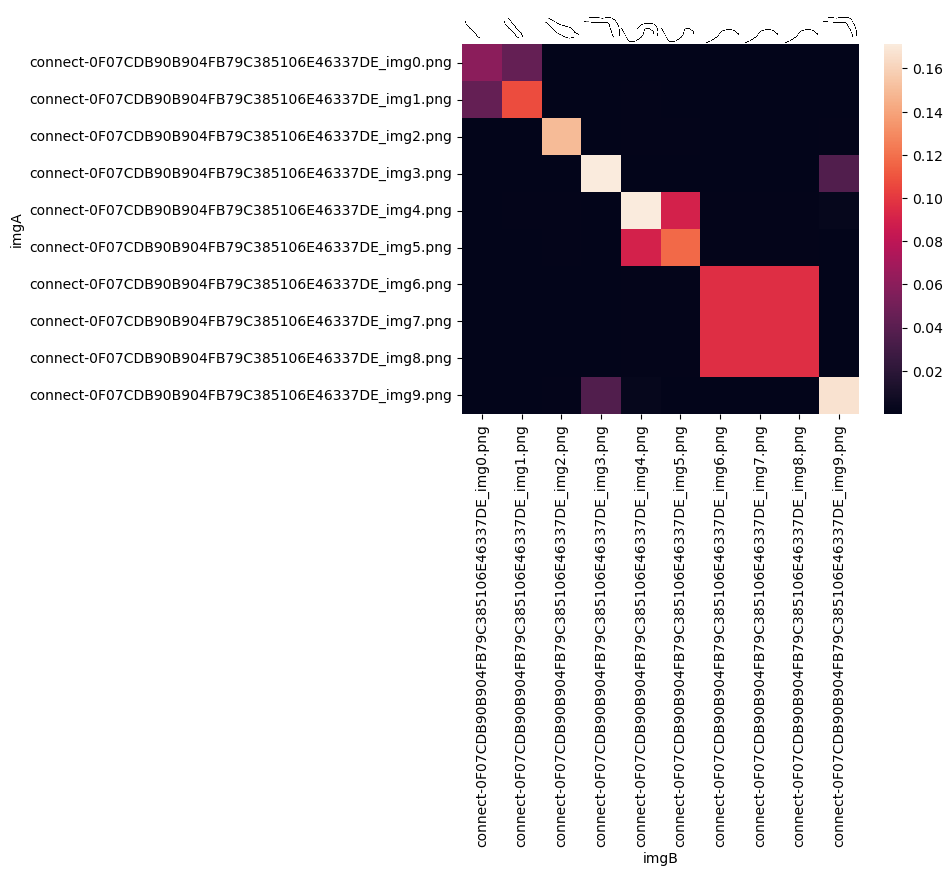

In [278]:
infodf = samplemidf.pivot(index="imgA", columns="imgB", values="mutualinfo")
ax = sns.heatmap(infodf)

tick_labels = ax.xaxis.get_ticklabels()

for i,im in enumerate(axis_imgs):
    ib = OffsetImage(im, zoom=.035)
    ib.image.axes = ax
    ab = AnnotationBbox(ib,
                    tick_labels[i].get_position(),
                    frameon=False,
                    box_alignment=(0.5, 0)
                    )
    ax.add_artist(ab)

## Calculate average image

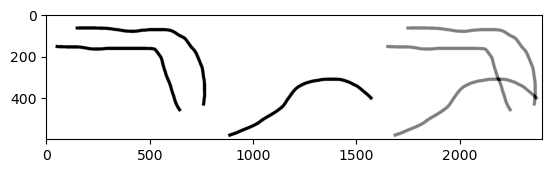

In [335]:
# average of 2 images
s1 = Dict['connect-0F07CDB90B904FB79C385106E46337DE_img3.png']
s2 = Dict['connect-0F07CDB90B904FB79C385106E46337DE_img6.png']
s1_arr = np.array(s1)
s2_arr = np.array(s2)
avg_arr = np.mean(np.array([s1_arr, s2_arr]), axis=0)
result_img = Image.fromarray(avg_arr.astype(np.uint8))
plt.imshow(np.hstack((s1, s2, result_img)))

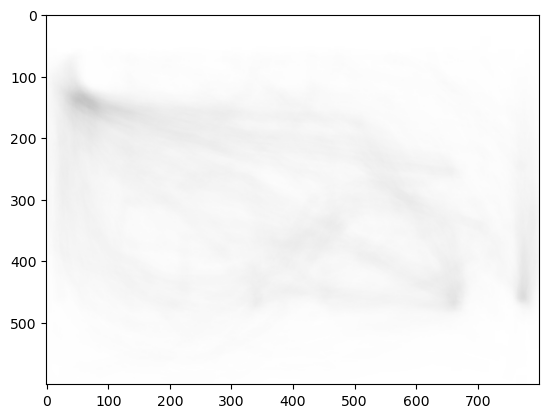

In [376]:
# average of all images
img_arrs = []
for d in Dict:
    img_arr = np.array(Dict[d])
    img_arrs.append(img_arr)

avg_arr = np.mean(np.array(img_arrs), axis=0)
result_img = Image.fromarray(avg_arr.astype(np.uint8))
plt.imshow(result_img)
result_img.save("fig/strokes/avgStroke.png")

basic_far


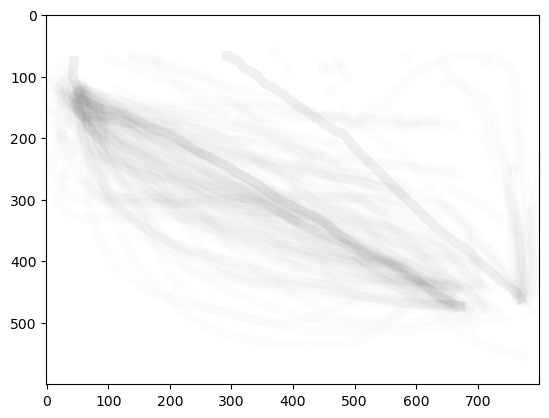

boomerang_left


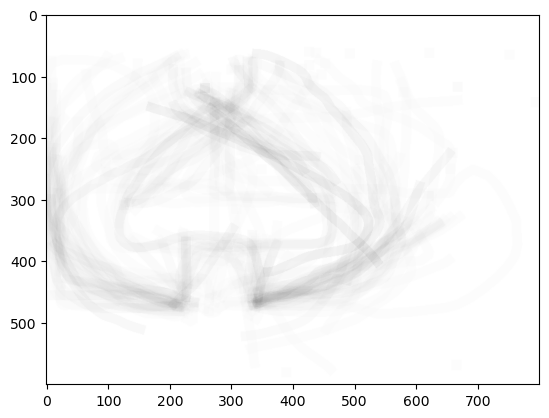

diagonal_descent


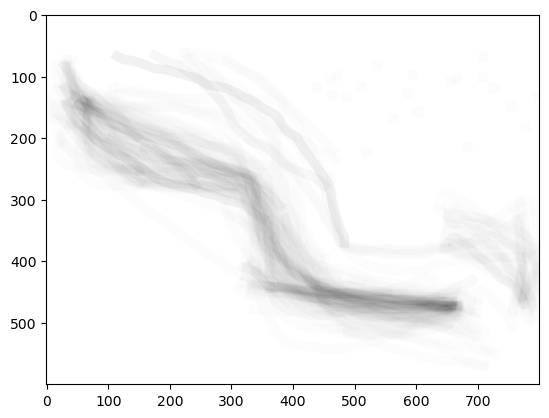

basic_flat


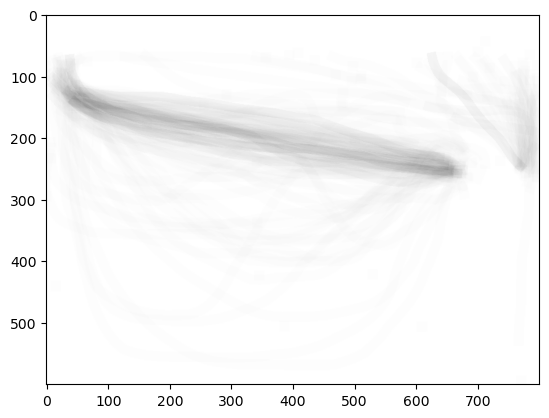

basic_short


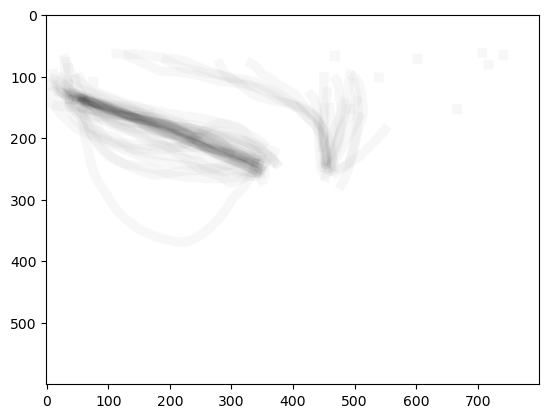

tunnel_wide


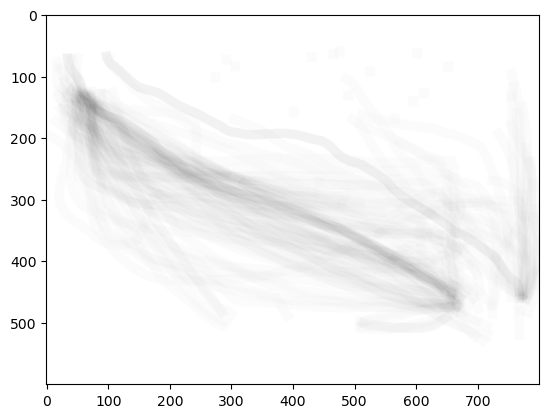

block_long


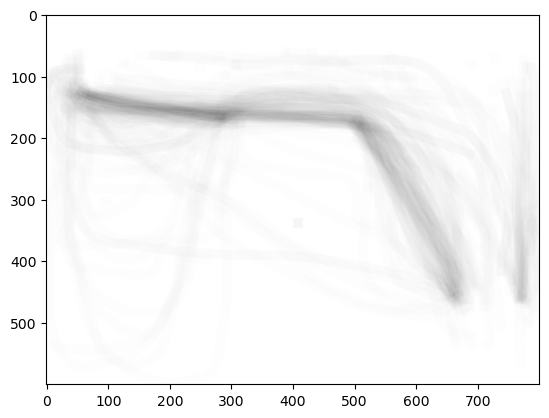

diagonal_ascent


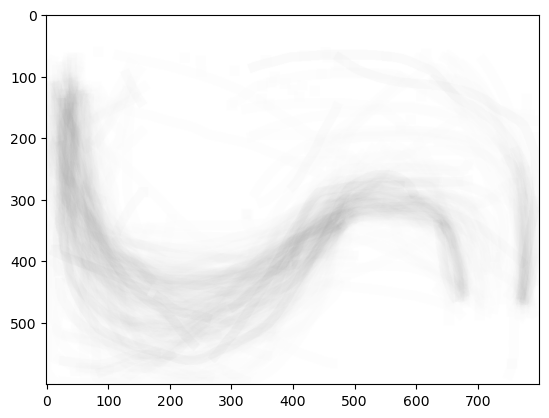

boomerang_middle


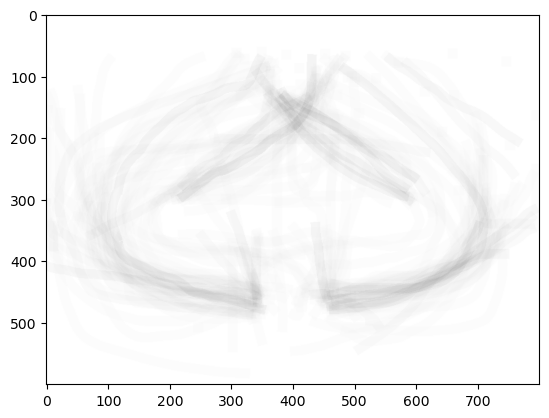

tunnel_narrow


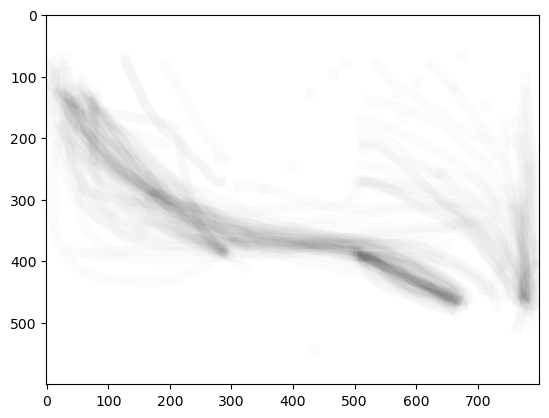

basic_drop


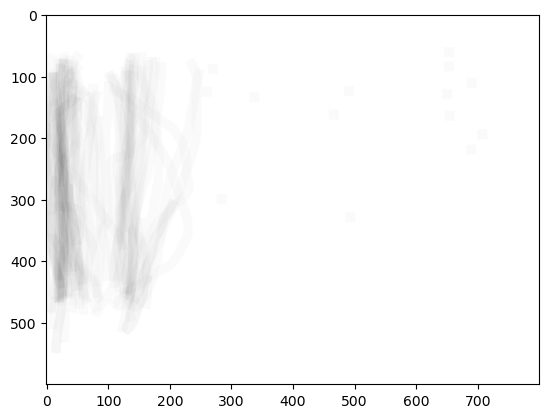

contain_corner


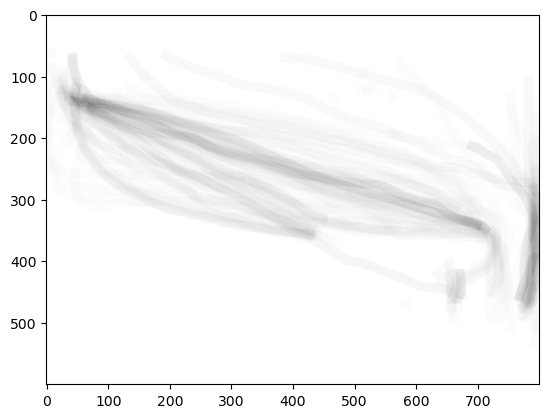

block_med


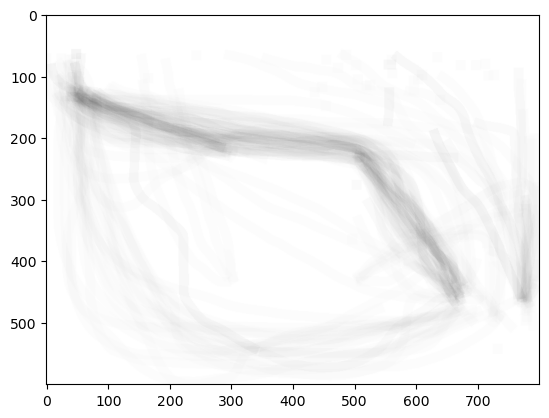

basic_steep


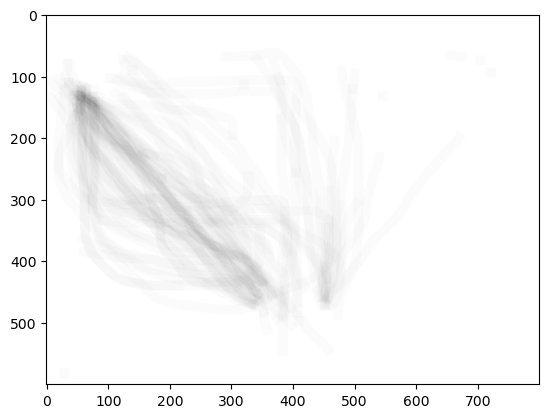

In [380]:
avgLevel = {}

for levelLabel in df['levelID'].unique():
    print(levelLabel)
    levelImgs = df[df['levelID'].str.contains(levelLabel)]['imageID']
    img_arrs = []
    for l in levelImgs:
        img_arr = np.array(Dict[l])
        img_arrs.append(img_arr)
    avgLevel[levelLabel] = np.mean(np.array(img_arrs), axis=0)
    result_img = Image.fromarray(avgLevel[levelLabel].astype(np.uint8))
    imgplot = plt.imshow(result_img)
    plt.show()
    result_img.save("fig/strokes/"+levelLabel+".png")

In [378]:
avgLevelCond = {}

## Calculate mutual information from average images

In [389]:
all_mi_toAvg = []

for d in Dict:
    s1 = Dict[d]
    s1_arr = np.asarray(s1).ravel()
    s2_arr = avg_arr.ravel()
    hist_2d, x_edges, y_edges = np.histogram2d(s1_arr,s2_arr,bins=20)
    row = {'img': d, 'mutualinfo': mutual_information(hist_2d)}
    all_mi_toAvg.append(row) 

<Axes: xlabel='mutualinfo', ylabel='Count'>

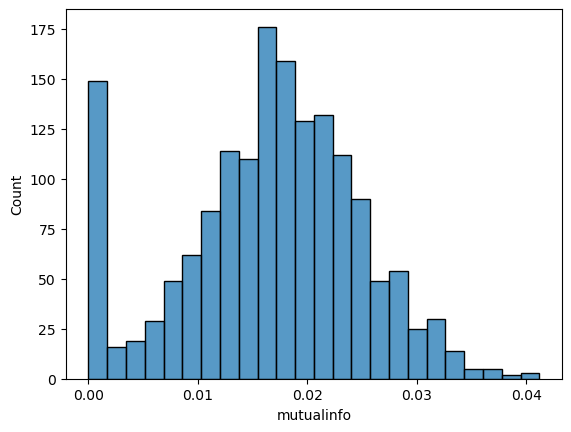

In [393]:
all_mi_toAvg_df = pd.DataFrame(all_mi_toAvg)
sns.histplot(data=all_mi_toAvg_df, x="mutualinfo")

In [440]:
all_mi_toLvl = []

for d in Dict:
    if df[df['imageID'].str.contains(d)] is not None:
        s1 = Dict[d]
        s1_arr = np.asarray(s1).ravel()
        s1_levelID = df[df['imageID'].str.contains(d)]['levelID'].iloc[0]
        s2_arr = avgLevel[s1_levelID].ravel()
        hist_2d, x_edges, y_edges = np.histogram2d(s1_arr,s2_arr,bins=20)
        row = {'img': d, 'level':s1_levelID, 'mutualinfo': mutual_information(hist_2d)}
        all_mi_toLvl.append(row) 

{'img': 'connect-F8D52DE7E5634302BB8D6890E6DDBA3F_img38.png', 'level': 'block_long', 'mutualinfo': 0.041716302400719385}
{'img': 'connect-F8D52DE7E5634302BB8D6890E6DDBA3F_img10.png', 'level': 'contain_corner', 'mutualinfo': 0.05255745934090106}
{'img': 'connect-F8D52DE7E5634302BB8D6890E6DDBA3F_img11.png', 'level': 'contain_corner', 'mutualinfo': 0.06475064102018327}
{'img': 'connect-F8D52DE7E5634302BB8D6890E6DDBA3F_img39.png', 'level': 'block_long', 'mutualinfo': 0.041716302400719385}
{'img': 'connect-F8D52DE7E5634302BB8D6890E6DDBA3F_img13.png', 'level': 'contain_corner', 'mutualinfo': 0.05913455133649566}
{'img': 'connect-F8D52DE7E5634302BB8D6890E6DDBA3F_img12.png', 'level': 'contain_corner', 'mutualinfo': 0.059926600230623114}
{'img': 'connect-F8D52DE7E5634302BB8D6890E6DDBA3F_img16.png', 'level': 'basic_steep', 'mutualinfo': 0.036725835422307916}
{'img': 'connect-F8D52DE7E5634302BB8D6890E6DDBA3F_img9.png', 'level': 'contain_corner', 'mutualinfo': 0.044728930858751376}
{'img': 'connec

{'img': 'connect-BDE67C2DF7E34C829465442702DD3ACC_img40.png', 'level': 'block_med', 'mutualinfo': 0.038657097772761426}
{'img': 'connect-BDE67C2DF7E34C829465442702DD3ACC_img41.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.02817301113686396}
{'img': 'connect-BDE67C2DF7E34C829465442702DD3ACC_img3.png', 'level': 'tunnel_narrow', 'mutualinfo': 0.0427810508098074}
{'img': 'connect-BDE67C2DF7E34C829465442702DD3ACC_img1.png', 'level': 'tunnel_narrow', 'mutualinfo': 0.026932125552232185}
{'img': 'connect-BDE67C2DF7E34C829465442702DD3ACC_img43.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.04753856411027818}
{'img': 'connect-BDE67C2DF7E34C829465442702DD3ACC_img42.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.03671827543727766}
{'img': 'connect-BDE67C2DF7E34C829465442702DD3ACC_img0.png', 'level': 'tunnel_narrow', 'mutualinfo': 0.043881761426645155}
{'img': 'connect-BDE67C2DF7E34C829465442702DD3ACC_img49.png', 'level': 'basic_drop', 'mutualinfo': 0.052571134462405064}
{'img': 'connect-

{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img20.png', 'level': 'boomerang_middle', 'mutualinfo': 0.006852394361037599}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img21.png', 'level': 'boomerang_middle', 'mutualinfo': 0.026547071586781816}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img35.png', 'level': 'basic_far', 'mutualinfo': 0.027265806960310283}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img23.png', 'level': 'boomerang_middle', 'mutualinfo': 0.006729071400420791}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img37.png', 'level': 'basic_far', 'mutualinfo': 0.02974119271399485}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img36.png', 'level': 'basic_far', 'mutualinfo': 0.03559405947107734}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img22.png', 'level': 'boomerang_middle', 'mutualinfo': 0.02197718159648511}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img26.png', 'level': 'basic_drop', 'mutualinfo': 0.016440679417692883}
{'img': 'conne

{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img74.png', 'level': 'contain_corner', 'mutualinfo': 0.02002268878125112}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img60.png', 'level': 'basic_steep', 'mutualinfo': 0.03207983805880451}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img48.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.0471132156792849}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img64.png', 'level': 'basic_steep', 'mutualinfo': 0.03543049003314579}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img70.png', 'level': 'contain_corner', 'mutualinfo': 0.021304907884383415}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img58.png', 'level': 'boomerang_left', 'mutualinfo': 0.016185767910372604}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img4.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.025291372819795342}
{'img': 'connect-EC304583F3AC4B45B6B79A840A0443A0_img5.png', 'level': 'basic_flat', 'mutualinfo': 0.003746605251731529}
{'img': 'connec

{'img': 'connect-1304BAAAAFA04DEE959F8EC00A5E49F6_img0.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.00029722103973144873}
{'img': 'connect-1304BAAAAFA04DEE959F8EC00A5E49F6_img38.png', 'level': 'block_med', 'mutualinfo': 0.05778530839898028}
{'img': 'connect-1304BAAAAFA04DEE959F8EC00A5E49F6_img10.png', 'level': 'block_med', 'mutualinfo': 0.060642075774282676}
{'img': 'connect-1304BAAAAFA04DEE959F8EC00A5E49F6_img11.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.05438024722625027}
{'img': 'connect-1304BAAAAFA04DEE959F8EC00A5E49F6_img39.png', 'level': 'block_med', 'mutualinfo': 0.03195451025998142}
{'img': 'connect-1304BAAAAFA04DEE959F8EC00A5E49F6_img1.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.046014232686585055}
{'img': 'connect-1304BAAAAFA04DEE959F8EC00A5E49F6_img5.png', 'level': 'basic_steep', 'mutualinfo': 0.03465859464764026}
{'img': 'connect-1304BAAAAFA04DEE959F8EC00A5E49F6_img15.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.05388351453376822}
{'img': 'connect-130

{'img': 'connect-6F75D8B9C091457AB35203CFF4BE2103_img14.png', 'level': 'basic_drop', 'mutualinfo': 0.021777818631764}
{'img': 'connect-6F75D8B9C091457AB35203CFF4BE2103_img28.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.04171585369062722}
{'img': 'connect-6F75D8B9C091457AB35203CFF4BE2103_img29.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.040196370819438915}
{'img': 'connect-6F75D8B9C091457AB35203CFF4BE2103_img15.png', 'level': 'diagonal_descent', 'mutualinfo': 0.03468885555293208}
{'img': 'connect-6F75D8B9C091457AB35203CFF4BE2103_img66.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.016094016108792603}
{'img': 'connect-6F75D8B9C091457AB35203CFF4BE2103_img72.png', 'level': 'basic_flat', 'mutualinfo': 0.03296814106800469}
{'img': 'connect-6F75D8B9C091457AB35203CFF4BE2103_img8.png', 'level': 'basic_flat', 'mutualinfo': 0.03215256850153933}
{'img': 'connect-6F75D8B9C091457AB35203CFF4BE2103_img9.png', 'level': 'basic_flat', 'mutualinfo': 0.03721571076197885}
{'img': 'connect-6F75

{'img': 'connect-A4CF186F80ED41E6973870DB4C597F32_img16.png', 'level': 'basic_drop', 'mutualinfo': 0.015713309974313666}
{'img': 'connect-A4CF186F80ED41E6973870DB4C597F32_img17.png', 'level': 'basic_flat', 'mutualinfo': 0.058793760549775295}
{'img': 'connect-A4CF186F80ED41E6973870DB4C597F32_img15.png', 'level': 'boomerang_left', 'mutualinfo': 0.02073368157351814}
{'img': 'connect-A4CF186F80ED41E6973870DB4C597F32_img29.png', 'level': 'tunnel_wide', 'mutualinfo': 0.014311821857509652}
{'img': 'connect-A4CF186F80ED41E6973870DB4C597F32_img28.png', 'level': 'basic_steep', 'mutualinfo': 0.024086745764727076}
{'img': 'connect-A4CF186F80ED41E6973870DB4C597F32_img14.png', 'level': 'boomerang_left', 'mutualinfo': 0.016301635118749484}
{'img': 'connect-A4CF186F80ED41E6973870DB4C597F32_img8.png', 'level': 'tunnel_narrow', 'mutualinfo': 0.03784883801509362}
{'img': 'connect-A4CF186F80ED41E6973870DB4C597F32_img9.png', 'level': 'basic_drop', 'mutualinfo': 0.05540035901893131}
{'img': 'connect-A4CF186

{'img': 'connect-5F8C795604094A3CB7FDE1F1A3955387_img9.png', 'level': 'block_long', 'mutualinfo': 0.045790004866604395}
{'img': 'connect-5F8C795604094A3CB7FDE1F1A3955387_img36.png', 'level': 'basic_drop', 'mutualinfo': 0.030421157485769103}
{'img': 'connect-5F8C795604094A3CB7FDE1F1A3955387_img22.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.03648261911074331}
{'img': 'connect-5F8C795604094A3CB7FDE1F1A3955387_img23.png', 'level': 'diagonal_ascent', 'mutualinfo': 0.05297730725611883}
{'img': 'connect-5F8C795604094A3CB7FDE1F1A3955387_img37.png', 'level': 'contain_corner', 'mutualinfo': 0.029357578960182533}
{'img': 'connect-35C167A8A69C44C6901146BCBDA40868_img50.png', 'level': 'boomerang_left', 'mutualinfo': 0.00027273061439695974}
{'img': 'connect-35C167A8A69C44C6901146BCBDA40868_img44.png', 'level': 'basic_drop', 'mutualinfo': 0.021476926801897417}
{'img': 'connect-35C167A8A69C44C6901146BCBDA40868_img45.png', 'level': 'basic_flat', 'mutualinfo': 0.0442496460117006}
{'img': 'connect-

{'img': 'connect-35C167A8A69C44C6901146BCBDA40868_img61.png', 'level': 'diagonal_descent', 'mutualinfo': 0.038449459786673086}
{'img': 'connect-1DF28D04D4BC4AD0A9B59DD0E935393A_img18.png', 'level': 'basic_far', 'mutualinfo': 0.027577928775990176}
{'img': 'connect-1DF28D04D4BC4AD0A9B59DD0E935393A_img30.png', 'level': 'basic_far', 'mutualinfo': 0.02729532720442681}
{'img': 'connect-1DF28D04D4BC4AD0A9B59DD0E935393A_img24.png', 'level': 'basic_far', 'mutualinfo': 0.013780289532104051}
{'img': 'connect-1DF28D04D4BC4AD0A9B59DD0E935393A_img25.png', 'level': 'basic_far', 'mutualinfo': 0.012348671096247002}
{'img': 'connect-1DF28D04D4BC4AD0A9B59DD0E935393A_img31.png', 'level': 'basic_far', 'mutualinfo': 0.016982100464001462}
{'img': 'connect-1DF28D04D4BC4AD0A9B59DD0E935393A_img19.png', 'level': 'basic_far', 'mutualinfo': 0.0220827467510362}
{'img': 'connect-1DF28D04D4BC4AD0A9B59DD0E935393A_img27.png', 'level': 'basic_far', 'mutualinfo': 0.018281820689850483}
{'img': 'connect-1DF28D04D4BC4AD0A9B

{'img': 'connect-AF702843D08345DDB622016021A53AD9_img11.png', 'level': 'boomerang_middle', 'mutualinfo': 0.032841380703035744}
{'img': 'connect-AF702843D08345DDB622016021A53AD9_img39.png', 'level': 'basic_steep', 'mutualinfo': 0.02940484155788924}
{'img': 'connect-AF702843D08345DDB622016021A53AD9_img1.png', 'level': 'tunnel_narrow', 'mutualinfo': 0.022262862654997644}
{'img': 'connect-AF702843D08345DDB622016021A53AD9_img0.png', 'level': 'tunnel_narrow', 'mutualinfo': 0.02859598966626093}
{'img': 'connect-AF702843D08345DDB622016021A53AD9_img38.png', 'level': 'basic_flat', 'mutualinfo': 0.045737591451357175}
{'img': 'connect-AF702843D08345DDB622016021A53AD9_img10.png', 'level': 'boomerang_middle', 'mutualinfo': 0.029027226595014916}
{'img': 'connect-AF702843D08345DDB622016021A53AD9_img28.png', 'level': 'block_long', 'mutualinfo': 0.04606810100026014}
{'img': 'connect-AF702843D08345DDB622016021A53AD9_img14.png', 'level': 'tunnel_wide', 'mutualinfo': 0.015769893688381657}
{'img': 'connect-

{'img': 'connect-AD5993CF4D3C4DCC8A62F2D5EE70755D_img47.png', 'level': 'tunnel_narrow', 'mutualinfo': 0.05249670481677774}
{'img': 'connect-AD5993CF4D3C4DCC8A62F2D5EE70755D_img53.png', 'level': 'tunnel_wide', 'mutualinfo': 0.07789648510611527}
{'img': 'connect-AD5993CF4D3C4DCC8A62F2D5EE70755D_img57.png', 'level': 'diagonal_descent', 'mutualinfo': 0.08315040356370623}
{'img': 'connect-AD5993CF4D3C4DCC8A62F2D5EE70755D_img43.png', 'level': 'boomerang_middle', 'mutualinfo': 0.033418072183048556}
{'img': 'connect-AD5993CF4D3C4DCC8A62F2D5EE70755D_img42.png', 'level': 'basic_far', 'mutualinfo': 0.07582078571229495}
{'img': 'connect-AD5993CF4D3C4DCC8A62F2D5EE70755D_img56.png', 'level': 'diagonal_descent', 'mutualinfo': 0.07810481766043856}
{'img': 'connect-AD5993CF4D3C4DCC8A62F2D5EE70755D_img40.png', 'level': 'basic_far', 'mutualinfo': 0.07787935854508715}
{'img': 'connect-AD5993CF4D3C4DCC8A62F2D5EE70755D_img54.png', 'level': 'tunnel_wide', 'mutualinfo': 0.07771329183615439}
{'img': 'connect-A

IndexError: single positional indexer is out-of-bounds

/Users/lo2069/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


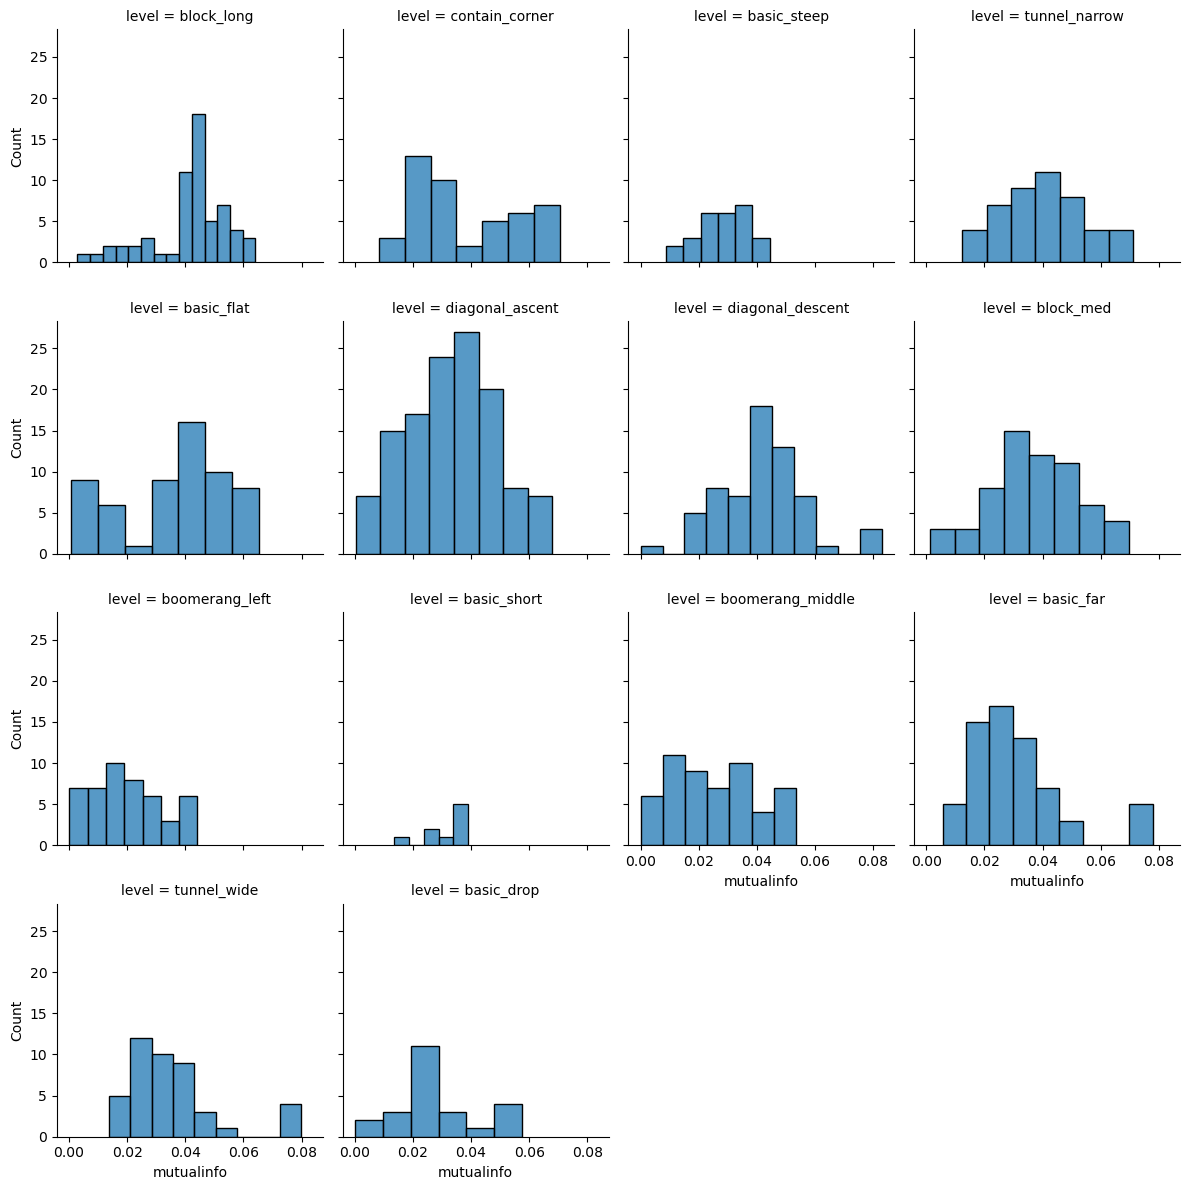

In [454]:
all_mi_toLvl_df = pd.DataFrame(all_mi_toLvl)
all_mi_toLvl_df
# sns.histplot(data=all_mi_toLvl_df, x="mutualinfo")
# sns.displot(data=all_mi_toLvl_df, x="mutualinfo", col="level",
#             binwidth=3, height=3, acet_kws=dict(margin_titles=True))

g = sns.FacetGrid(all_mi_toLvl_df, col="level", col_wrap=4)
g.map(sns.histplot, "mutualinfo")
g.savefig("fig/mi_levels.png")

# 